In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch.backends.cudnn as cudnn
import torch
import random
import ld_gan

In [3]:
from ld_gan.visualize import disp

# set parameters

In [4]:
RAND_SEED = 42
cudnn.benchmark = True
random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)
torch.cuda.manual_seed_all(RAND_SEED)

In [5]:
cudnn.benchmark = True
torch.cuda.manual_seed_all(RAND_SEED)

In [6]:
BATCH_SIZE  = 256
LATENT_SIZE = 256
LR_GAN = 0.0002
LR_AE  = 0.0001

# load data

In [7]:
X, Y = ld_gan.data_proc.data_loader.load_data(1, verbose=1, resize = 64)

100%|██████████| 102/102 [00:11<00:00,  8.44it/s]

load data from '/export/home/oblum/projects/ls_gan/data/flowers_102/jpg_128'


# init model

In [8]:
from ld_gan.models.init_weights import init_weights
import torch.nn as nn

In [9]:
class AE(nn.Module):
    
    def __init__(self, 
                 complexity = 64,
                 n_col = 3,
                 n_features = 256):
        
        super(AE, self).__init__()
        self.main = nn.Sequential(
            # BLOCK 0: 64 --> 32
            nn.Conv2d(n_col, complexity, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # BLOCK 1: 32 --> 16
            nn.Conv2d(complexity, complexity * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(complexity * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # BLOCK 2: 16 --> 8
            nn.Conv2d(complexity * 2, complexity * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(complexity * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # BLOCK 3: 8 --> 4
            nn.Conv2d(complexity * 4, complexity * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(complexity * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # BLOCK 4: 4 --> 1
            nn.Conv2d(complexity * 8, n_features, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # BLOCK 0: 1 --> 4
            nn.ConvTranspose2d(n_features, complexity*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(complexity*8),
            nn.ReLU(True),
            # BLOCK 1: 4 --> 8
            nn.ConvTranspose2d(complexity*8, complexity*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(complexity*4),
            nn.ReLU(True),
            # BLOCK 2: 8 --> 16
            nn.ConvTranspose2d(complexity*4, complexity*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(complexity*2),
            nn.ReLU(True),
            # BLOCK 3: 16 --> 32
            nn.ConvTranspose2d(complexity*2, complexity, 4, 2, 1, bias=False),
            nn.BatchNorm2d(complexity),
            nn.ReLU(True),
            # BLOCK 4: 32 --> 64
            nn.ConvTranspose2d(complexity, n_col, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.main.apply(init_weights)
        self.main.cuda()

    def forward(self, input):
        output = self.main(input)
        return output

In [10]:
ae = AE()

# train

In [23]:
import torch.optim as optim
from tqdm import tqdm
from ld_gan.data_proc.transformer import np_to_tensor, tensor_to_np

In [13]:
opt = optim.Adam(ae.parameters(), lr=0.0001)

In [14]:
sampler = ld_gan.sample.generate_rand_noise(X, Y, BATCH_SIZE, LATENT_SIZE)

In [25]:
criterion = nn.MSELoss()
criterion.cuda()

MSELoss (
)

In [ ]:
for i in tqdm(range(1000)):

    Z, _, X, _ = sampler.next()
    Z, X = np_to_tensor(Z, X)

    ae.zero_grad()
    x = ae(X)
    err = criterion(x, X)
    err.backward()
    mean_x = x.data.mean()
    opt.step()
    
    if i % 25 == 0:
    imgs = tensor_to_np(x)
    disp(imgs[:10])

 30%|███       | 304/1000 [01:44<03:49,  3.03it/s]

# init networks

In [9]:
gen = ld_gan.models.gen.gen_64()

In [10]:
dis = ld_gan.models.dis.dis_64()

# init train ops

In [11]:
#train_ops = [ld_gan.train_ops.GanDis(gen, dis, LEARNING_RATE),
#             ld_gan.train_ops.GanGen(gen, dis, LEARNING_RATE)]
train_ops = [ld_gan.train_ops.Gan(gen, dis, LEARNING_RATE)]

In [12]:
sampler = ld_gan.sample.generate_rand_noise(X, Y, BATCH_SIZE, LATENT_SIZE)

# train

In [13]:
trainer = ld_gan.trainer.Trainer(gen, 
                                 dis, 
                                 None, 
                                 train_ops,
                                 sampler,
                                 len(X))

100%|██████████| 63/63 [00:16<00:00,  3.90it/s]

0


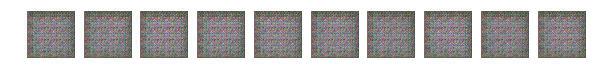

100%|██████████| 63/63 [00:15<00:00,  3.86it/s]

1


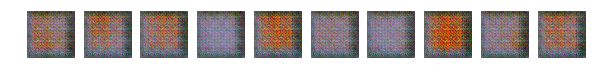

100%|██████████| 63/63 [00:15<00:00,  3.90it/s]

2


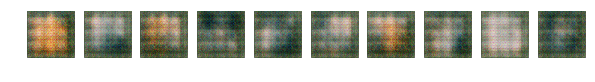

100%|██████████| 63/63 [00:15<00:00,  3.87it/s]

3


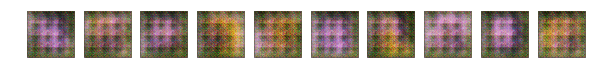

100%|██████████| 63/63 [00:10<00:00,  7.44it/s]

4


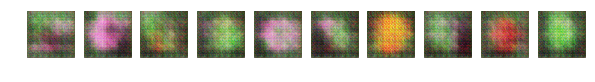

100%|██████████| 63/63 [00:08<00:00,  7.43it/s]

5


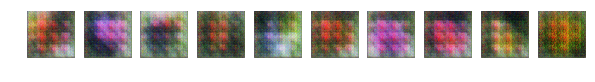

100%|██████████| 63/63 [00:08<00:00,  7.41it/s]

6


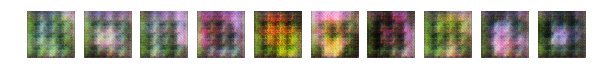

100%|██████████| 63/63 [00:08<00:00,  7.43it/s]

7


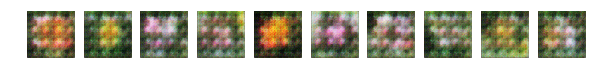

100%|██████████| 63/63 [00:08<00:00,  7.43it/s]

8


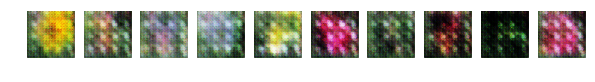

100%|██████████| 63/63 [00:08<00:00,  7.42it/s]

9


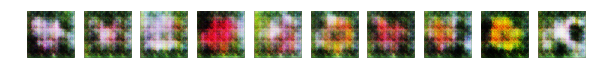

100%|██████████| 63/63 [00:08<00:00,  7.43it/s]

10


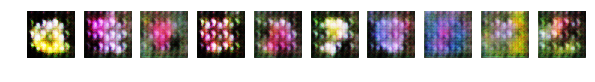

100%|██████████| 63/63 [00:08<00:00,  7.39it/s]

11


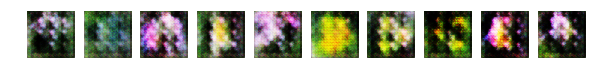

100%|██████████| 63/63 [00:08<00:00,  7.43it/s]

12


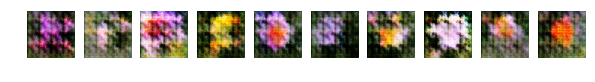

100%|██████████| 63/63 [00:15<00:00,  3.74it/s]

13


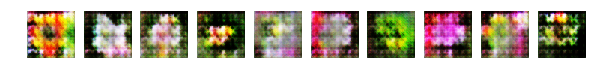

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

14


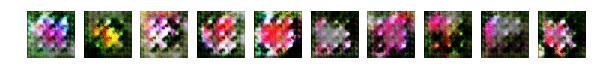

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

15


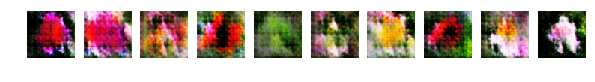

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

16


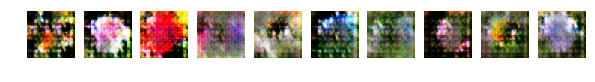

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

17


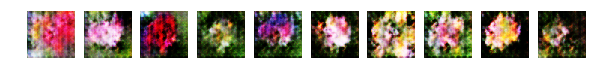

100%|██████████| 63/63 [00:16<00:00,  3.72it/s]

18


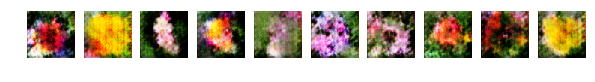

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

19


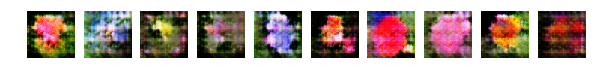

100%|██████████| 63/63 [00:16<00:00,  3.80it/s]

20


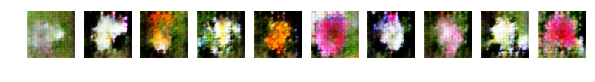

100%|██████████| 63/63 [00:16<00:00,  4.28it/s]

21


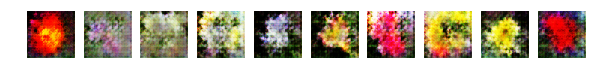

100%|██████████| 63/63 [00:16<00:00,  5.81it/s]

22


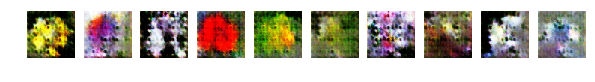

100%|██████████| 63/63 [00:16<00:00,  3.75it/s]

23


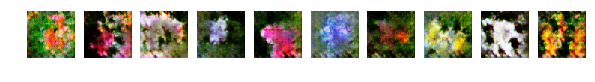

100%|██████████| 63/63 [00:16<00:00,  3.75it/s]

24


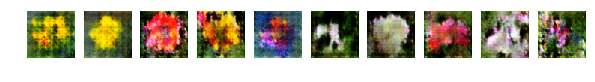

100%|██████████| 63/63 [00:16<00:00,  3.72it/s]

25


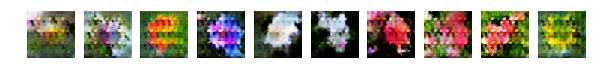

100%|██████████| 63/63 [00:16<00:00,  3.71it/s]

26


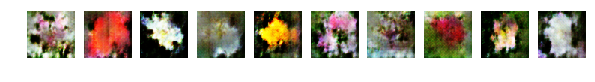

100%|██████████| 63/63 [00:15<00:00,  3.72it/s]

27


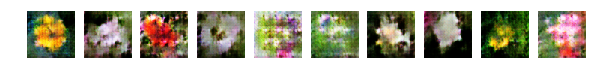

100%|██████████| 63/63 [00:16<00:00,  3.71it/s]

28


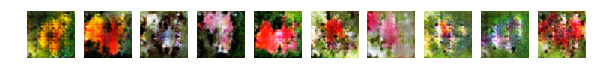

100%|██████████| 63/63 [00:16<00:00,  3.72it/s]

29


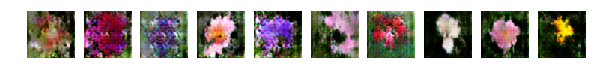

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

30


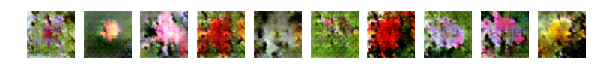

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

31


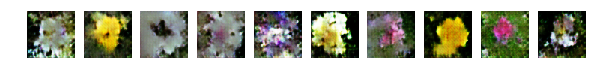

100%|██████████| 63/63 [00:16<00:00,  3.83it/s]

32


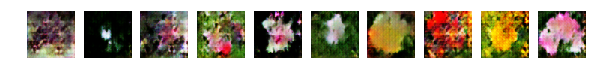

100%|██████████| 63/63 [00:16<00:00,  4.45it/s]

33


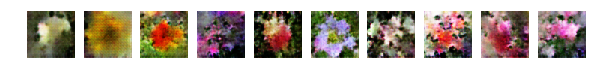

100%|██████████| 63/63 [00:16<00:00,  5.24it/s]

34


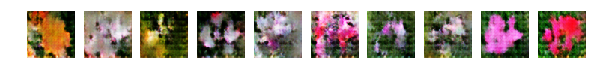

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

35


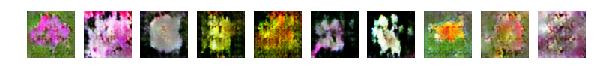

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

36


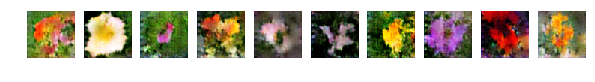

100%|██████████| 63/63 [00:16<00:00,  3.72it/s]

37


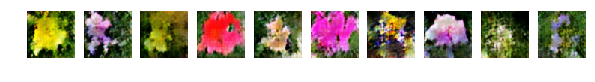

100%|██████████| 63/63 [00:16<00:00,  3.78it/s]

38


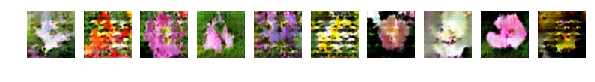

100%|██████████| 63/63 [00:16<00:00,  3.77it/s]

39


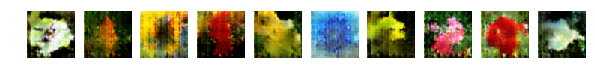

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

40


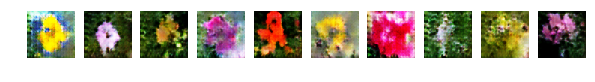

100%|██████████| 63/63 [00:16<00:00,  3.75it/s]

41


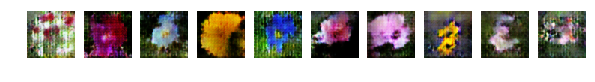

100%|██████████| 63/63 [00:16<00:00,  3.75it/s]

42


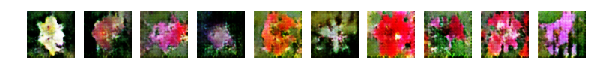

100%|██████████| 63/63 [00:16<00:00,  3.77it/s]

43


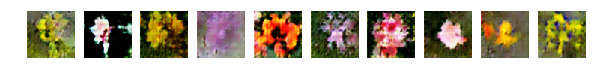

100%|██████████| 63/63 [00:15<00:00,  3.79it/s]

44


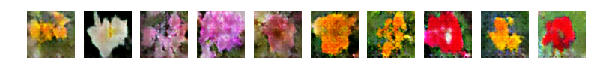

100%|██████████| 63/63 [00:16<00:00,  4.57it/s]

45


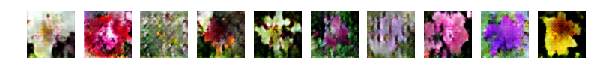

100%|██████████| 63/63 [00:16<00:00,  5.31it/s]

46


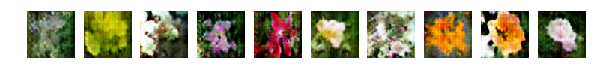

100%|██████████| 63/63 [00:16<00:00,  3.79it/s]

47


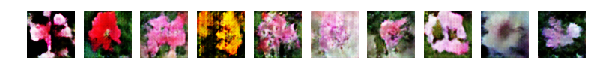

100%|██████████| 63/63 [00:16<00:00,  3.71it/s]

48


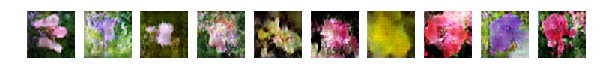

100%|██████████| 63/63 [00:15<00:00,  3.76it/s]

49


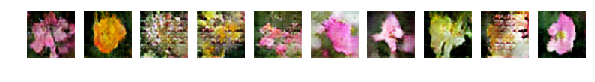

100%|██████████| 63/63 [00:16<00:00,  3.77it/s]

50


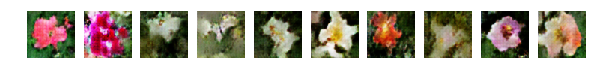

100%|██████████| 63/63 [00:16<00:00,  3.72it/s]

51


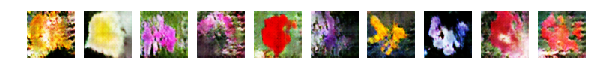

100%|██████████| 63/63 [00:16<00:00,  3.70it/s]

52


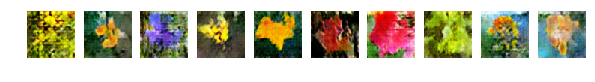

100%|██████████| 63/63 [00:16<00:00,  3.66it/s]

53


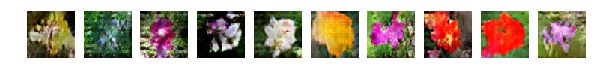

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

54


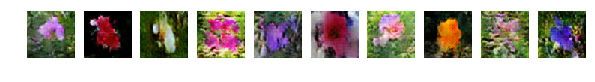

100%|██████████| 63/63 [00:16<00:00,  3.70it/s]

55


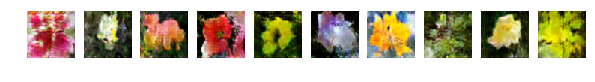

100%|██████████| 63/63 [00:15<00:00,  3.81it/s]

56


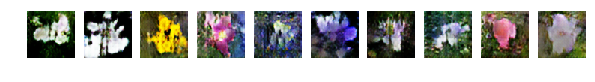

100%|██████████| 63/63 [00:16<00:00,  4.16it/s]

57


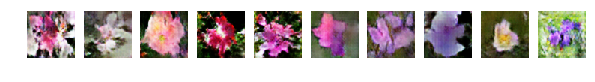

100%|██████████| 63/63 [00:16<00:00,  5.91it/s]

58


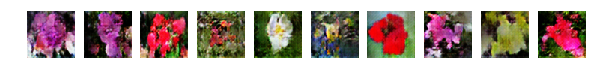

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

59


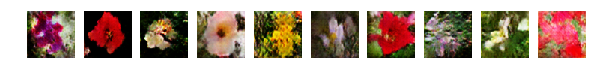

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

60


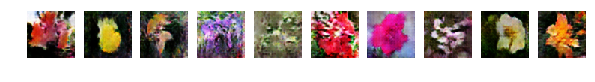

100%|██████████| 63/63 [00:15<00:00,  3.78it/s]

61


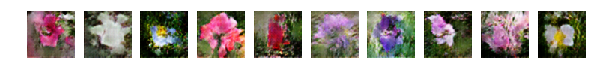

100%|██████████| 63/63 [00:16<00:00,  3.72it/s]

62


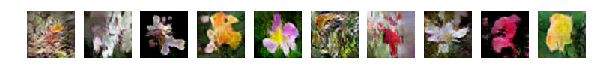

100%|██████████| 63/63 [00:16<00:00,  3.79it/s]

63


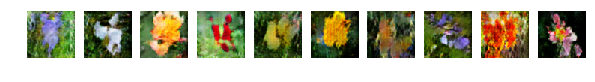

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

64


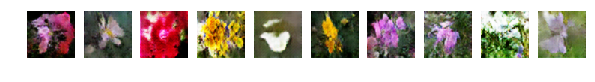

100%|██████████| 63/63 [00:16<00:00,  3.70it/s]

65


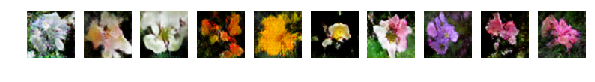

100%|██████████| 63/63 [00:16<00:00,  3.75it/s]

66


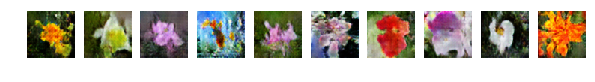

100%|██████████| 63/63 [00:15<00:00,  3.78it/s]

67


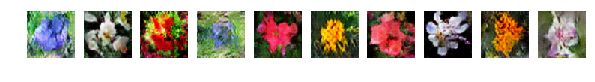

100%|██████████| 63/63 [00:15<00:00,  3.78it/s]

68


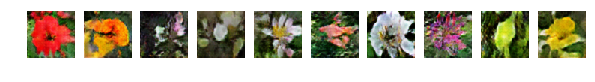

100%|██████████| 63/63 [00:16<00:00,  3.98it/s]

69


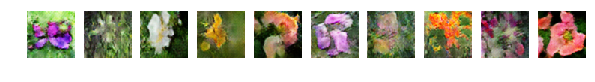

100%|██████████| 63/63 [00:16<00:00,  6.46it/s]

70


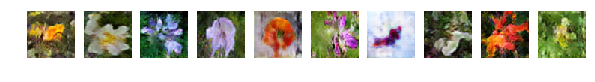

100%|██████████| 63/63 [00:16<00:00,  3.71it/s]

71


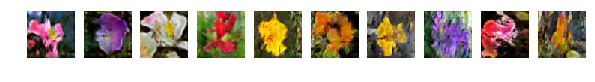

100%|██████████| 63/63 [00:16<00:00,  3.70it/s]

72


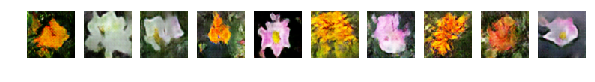

100%|██████████| 63/63 [00:16<00:00,  3.70it/s]

73


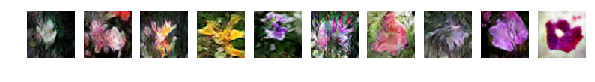

100%|██████████| 63/63 [00:16<00:00,  3.72it/s]

74


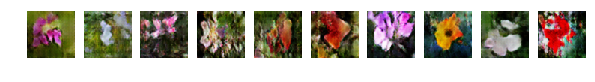

100%|██████████| 63/63 [00:15<00:00,  3.78it/s]

75


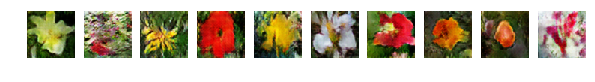

100%|██████████| 63/63 [00:16<00:00,  3.71it/s]

76


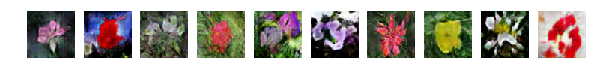

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

77


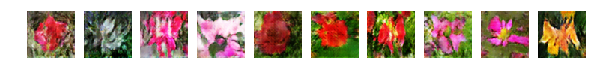

100%|██████████| 63/63 [00:16<00:00,  3.73it/s]

78


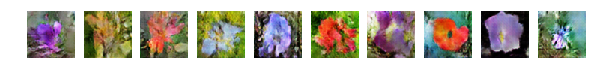

100%|██████████| 63/63 [00:16<00:00,  3.78it/s]

79


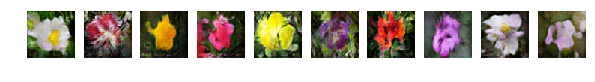

100%|██████████| 63/63 [00:15<00:00,  3.76it/s]

80


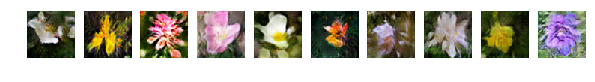

100%|██████████| 63/63 [00:16<00:00,  3.92it/s]

81


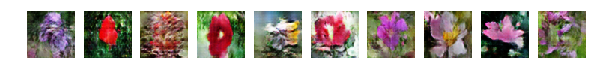

100%|██████████| 63/63 [00:16<00:00,  6.66it/s]

82


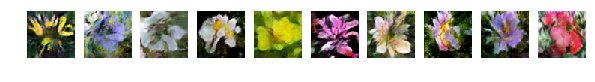

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

83


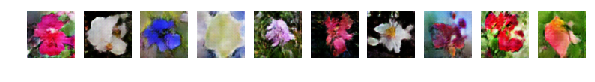

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

84


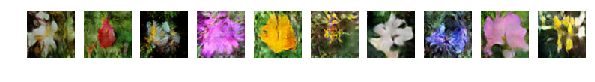

100%|██████████| 63/63 [00:16<00:00,  3.75it/s]

85


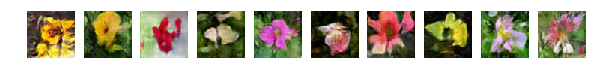

100%|██████████| 63/63 [00:16<00:00,  3.78it/s]

86


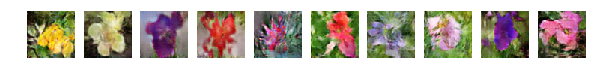

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]

87


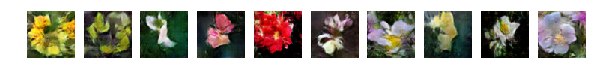

100%|██████████| 63/63 [00:16<00:00,  3.74it/s]

88


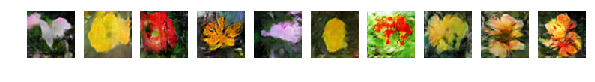

100%|██████████| 63/63 [00:15<00:00,  3.81it/s]

89


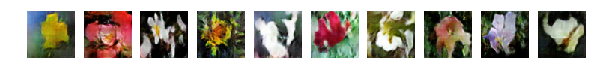

100%|██████████| 63/63 [00:16<00:00,  3.70it/s]

90


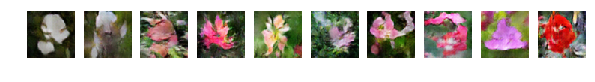

100%|██████████| 63/63 [00:12<00:00,  7.41it/s]

91


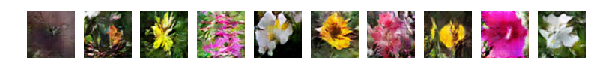

 21%|██        | 13/63 [00:01<00:06,  7.46it/s]


KeyboardInterrupt: 

In [14]:
trainer.train()

In [18]:
trainer.train_ops[0].__class__.__name__

'Gan'

In [26]:
with open('try.cvs', 'a') as f:
    f.write("new_line\n")